# Order Flow variable in LSTM forecast of the foreign exchange market



In [ ]:
###### FALTA POR MEJORAR: 
#     - ROLLING WINDOW APPROACH FOR NEXT HOUR FORECAST
#     - Modelar el gap entre hora de cierre y hora de apertura entre periodos de trading, ie. ¿Qué pasa entre
#         6:00 y 18:00. Revisar literatura sobre técnicas para conseguirlo.
#     - Para predicciones de más de un periodo: Rolling (no?) recursivo con simulaciones de Monte Carlo, Bootstrap, otros?
#     - Pensar en modelar la volatilidad con GARCH para mejorar el modelo ARMA anterior. Varianza cambia condicional
#         al periodo. 
#     - Revisar en literatura la elección de parámetros como 'hidden layer', 'epochs', 'batch_size', y OTROS
#     - Revisar en la literatura relevancia económica de modelos de predicción de tasa de cambio, porque ANN??
#     - Revisar el GRAVE PROBLEMA de conseguir los datos para Colombia en orden para que sea relevante e interesante

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

### Theorical framework

The importance of the order flow, among other advances in financial microstructure, has dominated the foreign exchange markets forecast literature in the past decade. Using data from the Reuters Information System between april and august 1996, Evans & Lyons (2001) argumented that the order flow was responsible of nearly 30% of the change in the final price of the risky foreign financial asset. The order flow is calculated as follows: $$\sum_{i=1}^{N}{(M_{i)} - (N_{i})}$$ Where $M_{i}$ represents the total buyer-initiated completed transactions and $N_{i}$ the total seller-initiated completed transactions in a given hour $i$.

A genetic algorithm, as the artificial neural network, provides a straight-forward approach to model this highly non-linear process of price determination. Also, this approach is robust enough to omit the noise in the data.

Furthermore, we need to implement a recurrent neural network (specifically a Long Short-Term Memory network) so that the modeling function can map the inputs to an output explicitly handling the new sequence dimension. Also, this kind of models can learn the temporal dependence from the data, which means that the context in a specific moment of time is taking into account by the modeling function.

### Time series to supervised learning dataset
First of all, a transformation of the dataset from a time series-indexed to a supervised learning pandas array. The function we use to perform this transformation is available at https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [3]:
from pandas import DataFrame
from pandas import concat

#Función de machinelearningmastery.com
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Initially we import the dataset from a csv file and format it to fit the transforming function. Then, descriptive statistics and the first rows are presented.

It is important to note in it that the order flow variable is indeed correlate to the hourly change in price. 

In [42]:
dataset = pd.read_csv('primeraEntrega/datos.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
dataset.describe()

,price,last_sale_price_in _hour,average_price,sd_of_purchase_prices_in_hour,sd_of _sale_prices_in_hour,number_of_trades,number_of_buys,number_sales,number_of_announcements,order_flow,change_price,log_price
count,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,2424.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,1.509941,1.509881,1.509911,0.650256,0.655849,217.572674,105.047855,108.937984,0.890504,-2.702519,-0.000025,-0.000013
std,0.023997,0.024013,0.024003,0.451857,0.448047,147.590221,138.420920,75.570074,1.094305,155.794730,0.001258,0.000552
min,1.467000,1.466900,1.466950,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,-474.000000,-0.012364,-0.005370
25%,1.485000,1.484800,1.484863,0.405025,0.410340,112.000000,4.000000,54.000000,0.000000,-96.000000,-0.000592,-0.000258
50%,1.520750,1.520550,1.520675,0.586431,0.587206,200.000000,41.000000,97.000000,1.000000,-30.000000,0.000000,0.000000
75%,1.530400,1.530325,1.530337,0.784171,0.798898,288.000000,170.000000,146.000000,1.000000,67.000000,0.000524,0.000228
max,1.548600,1.549500,1.548550,6.964123,6.848557,1091.000000,1091.000000,543.000000,6.000000,833.000000,0.009472,0.004114


In [43]:
dataset.head()


,price,last_sale_price_in _hour,average_price,sd_of_purchase_prices_in_hour,sd_of _sale_prices_in_hour,number_of_trades,number_of_buys,number_sales,number_of_announcements,order_flow,change_price,log_price
date,,,,,,,,,,,,
1/05/96 6:00,1.5336,1.5337,1.53365,0.111270,0.191485,11.0,21,4.0,0.0,17.0,0.000000,0.000000
1/05/96 7:00,1.5322,1.5325,1.53235,0.805260,1.019570,48.0,26,13.0,2.0,13.0,-0.000913,-0.000397
1/05/96 8:00,1.5300,1.5318,1.53090,0.758654,0.700872,45.0,20,24.0,0.0,-4.0,-0.001437,-0.000624
1/05/96 9:00,1.5316,1.5343,1.53295,0.589491,0.633114,53.0,14,33.0,0.0,-19.0,0.001045,0.000454
1/05/96 10:00,1.5350,1.5347,1.53485,0.863529,0.698212,157.0,9,70.0,0.0,-61.0,0.002217,0.000963


Finally, we can apply the transformation function so that our dataset takes the form of a supervised learning array that we can fit into the keras library algorithms.

In [44]:
reframed = series_to_supervised(values,1,1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,1.5336,1.5337,1.53365,0.111270,0.191485,11.0,21.0,4.0,0.0,17.0,...,1.53235,0.805260,1.019570,48.0,26.0,13.0,2.0,13.0,-0.000913,-0.000397
2,1.5322,1.5325,1.53235,0.805260,1.019570,48.0,26.0,13.0,2.0,13.0,...,1.53090,0.758654,0.700872,45.0,20.0,24.0,0.0,-4.0,-0.001437,-0.000624
3,1.5300,1.5318,1.53090,0.758654,0.700872,45.0,20.0,24.0,0.0,-4.0,...,1.53295,0.589491,0.633114,53.0,14.0,33.0,0.0,-19.0,0.001045,0.000454
4,1.5316,1.5343,1.53295,0.589491,0.633114,53.0,14.0,33.0,0.0,-19.0,...,1.53485,0.863529,0.698212,157.0,9.0,70.0,0.0,-61.0,0.002217,0.000963
5,1.5350,1.5347,1.53485,0.863529,0.698212,157.0,9.0,70.0,0.0,-61.0,...,1.53515,0.463844,0.471362,76.0,11.0,29.0,0.0,-18.0,0.000000,0.000000
6,1.5350,1.5353,1.53515,0.463844,0.471362,76.0,11.0,29.0,0.0,-18.0,...,1.53470,0.269774,0.195180,27.0,48.0,13.0,0.0,35.0,-0.000195,-0.000085
7,1.5347,1.5347,1.53470,0.269774,0.195180,27.0,48.0,13.0,0.0,35.0,...,1.53760,1.062159,0.925301,69.0,45.0,39.0,0.0,6.0,0.001823,0.000792
8,1.5375,1.5377,1.53760,1.062159,0.925301,69.0,45.0,39.0,0.0,6.0,...,1.53560,1.222066,0.803050,111.0,53.0,59.0,1.0,-6.0,-0.001758,-0.000763
9,1.5348,1.5364,1.53560,1.222066,0.803050,111.0,53.0,59.0,1.0,-6.0,...,1.53250,0.141421,0.000000,4.0,157.0,2.0,0.0,155.0,-0.001043,-0.000453
10,1.5332,1.5318,1.53250,0.141421,0.000000,4.0,157.0,2.0,0.0,155.0,...,1.53360,0.750152,0.531550,121.0,76.0,62.0,0.0,14.0,0.000261,0.000113


We drop all explaining variables in time $t$ as we are only interested in the target variable at that moment of time. That way, we are left with an $X$ array of predictor variables in $t-1$ and a column vector $Y$ of the target variable in $t$.

In [45]:
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19,20,21,23]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var11(t)
1,1.5336,1.5337,1.53365,0.111270,0.191485,11.0,21.0,4.0,0.0,17.0,0.000000,-0.000913
2,1.5322,1.5325,1.53235,0.805260,1.019570,48.0,26.0,13.0,2.0,13.0,-0.000913,-0.001437
3,1.5300,1.5318,1.53090,0.758654,0.700872,45.0,20.0,24.0,0.0,-4.0,-0.001437,0.001045
4,1.5316,1.5343,1.53295,0.589491,0.633114,53.0,14.0,33.0,0.0,-19.0,0.001045,0.002217
5,1.5350,1.5347,1.53485,0.863529,0.698212,157.0,9.0,70.0,0.0,-61.0,0.002217,0.000000


In [46]:
values = reframed.values
n_train_hours = 1007
train = values[:n_train_hours, :]
test = values[n_train_hours:,:]
train_X, train_y = train[:,:10], train[:,11]
test_X, test_y = test[:,:10], test[:,11]

Next we normalize the values so that the inputs are at a comparable range.

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_x = scaler.fit_transform(train_X)
scaled_test_x = scaler.fit_transform(test_X)

In [48]:
train_X = scaled_train_x.reshape((scaled_train_x.shape[0], 1, scaled_train_x.shape[1]))
test_X = scaled_test_x.reshape((scaled_test_x.shape[0], 1, scaled_test_x.shape[1]))

### Hyper-parameters configuration
We choose the mean squared error as our learning target to minimize, we set the number of epochs to 300, number of hidden layers to 5 and the batch size to 1 observation.

We choose to train a multiceptron model of size 3 so the neural networks can model highly non-linear relationships between predictor variables. We hope that this approach can take into account convexities.

The rest of the values do not follow a logic rule of specification but instead are chosen through experimentation until optimal results.

### Model Training
Finally we can feed the algorithm with the data so the learning process can begin. At this stage we choose to implement a computationally efficient extension of the stochastic gradient descent called 'Adam'. Please see https://arxiv.org/abs/1412.6980 for further information. 

In [49]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=300, batch_size=80, validation_data=(test_X, test_y), verbose=0, shuffle=False)

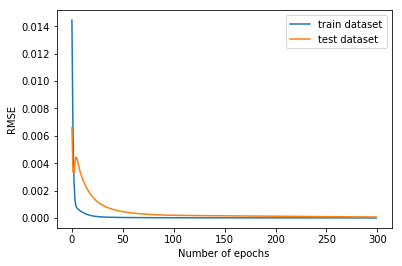

In [50]:
plt.plot(history.history['loss'], label="train dataset")
plt.plot(history.history['val_loss'], label="test dataset")
plt.xlabel('Number of epochs')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('error_test.pdf', bbox_inches='tight')
plt.show()

In [51]:
from numpy import concatenate
yhat = model.predict(test_X)
rmse = mean_squared_error(test_y, yhat)
print('Test RMSE: %.6f' % rmse)

Test RMSE: 0.000069


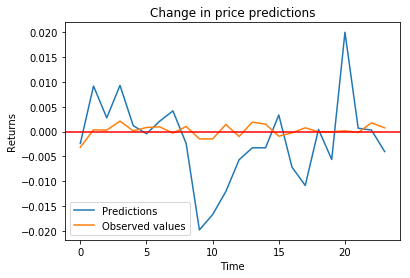

In [52]:
plt.plot(yhat, label='Predictions')
plt.plot(test_y, label='Observed values')
plt.title('Change in price predictions')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend(loc='lower left')
plt.savefig('predicciones_lstm.pdf', bbox_inches='tight')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


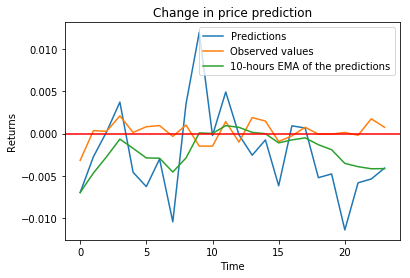

In [40]:
retornos_suavizados = pd.ewma(yhat, com=5)
plt.plot(yhat, label='Predictions')
plt.plot(test_y, label='Observed values')
plt.plot(retornos_suavizados, label='10-hours EMA of the predictions')
plt.title('Change in price prediction')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.savefig('predicciones_ema.pdf', bbox_inches='tight')
plt.show()

### Conclusions
The predictions made by the algorithm for the next 24 hours are far more reliable and exact at the beginning hours. That being said, is possible that the prediction power of the order flow variable dissipates throughout the day. The root mean squared error of the model training is $$. 

The algorithm can model the functional form of the generating process quite accurately but it needs to be more precise. A hybrid approach or a rolling window scheme can elevate it.

In consequence, the next logical approach is to set up a rolling window prediction system that predicts returns in FX market of the inmediate next hour and takes into account the values that have already happened.